In [ ]:

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer, RobertaForSequenceClassification
from transformers import AdamW
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.spatial.distance import cosine
from transformers import AutoModel, AutoTokenize


ImportError: cannot import name 'AutoTokenize' from 'transformers' (/opt/conda/lib/python3.9/site-packages/transformers/__init__.py)

In [2]:
N = 5
data = []
labels = []

train_samples = []
train_labels = []

valid_samples = []
valid_labels = []

test_samples = []
test_labels = []

embed_dim = 768
batch_size = 16
lr=2e-3  # you can adjust 
temp = 0.3  # you can adjust 
lamda = 0.01  # you can adjust  
skip_time = 0 # the number of time that yi not equal to yj in supervised contrastive loss equation 
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

### The Aim of these training is to fine tuning on few shot setting on text classification task

Path example of train, validation and test 

In [3]:
path_5shot = f'../../../../Thesis/CLINC150/train_5/'
valid_path = f'../../../../Thesis/CLINC150/valid/'
test_path = f'../../../../Thesis/CLINC150//test/'

In [4]:
# Import our models. The package will take care of downloading the models automatically
tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/sup-simcse-bert-base-uncased")

In [5]:
# Download data fewshot 
# https://downgit.github.io/#/home?url=https:%2F%2Fgithub.com%2Fjianguoz%2FFew-Shot-Intent-Detection%2Ftree%2Fmain%2FDatasets%2FHWU64

# load data
train_samples = load_examples(path_5shot)
valid_samples = load_examples(valid_path)
test_samples = load_examples(test_path)


print("===== small train set ====")

for i in range(len(train_samples)):
    data.append(train_samples[i].text)
    labels.append(train_samples[i].label)


train_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=False)
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)



print("===== validation set ====")

data = []
labels = []

for i in range(len(valid_samples)):
    data.append(valid_samples[i].text)
    labels.append(valid_samples[i].label)

valid_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=False)
valid_loader = DataLoader(valid_data,batch_size=batch_size,shuffle=True)



print("===== test set ====")

data = []
labels = []
    
for i in range(len(test_samples)):
    data.append(test_samples[i].text)
    labels.append(test_samples[i].label)

test_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=False)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=True)



# got the number of unique classes from dataset
num_class = len(np.unique(np.array(labels)))

# get text label of uniqure classes
unique_label = np.unique(np.array(labels))

# map text label to index classes
label_maps = {unique_label[i]: i for i in range(len(unique_label))}

===== small train set ====
Train on Cross Entropy loss
len of dataset : 750
===== validation set ====
Train on Cross Entropy loss
len of dataset : 3000
===== test set ====
Train on Cross Entropy loss
len of dataset : 4500


In [6]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
simcse = AutoModel.from_pretrained("princeton-nlp/sup-simcse-bert-base-uncased")
config = AutoConfig.from_pretrained("bert-base-uncased")
config.num_labels = 150
model = AutoModelForSequenceClassification.from_config(config)

In [7]:
with torch.no_grad():
    
    for new_name, new_param in model.named_parameters():

        new_keys = new_name.split(".")

        for old_name, old_param in simcse.named_parameters():

            old_keys = old_name.split(".")

            if new_keys[1:] == old_keys:
                # print("-----------------------")
                # print(new_keys[1:])
                # print(old_keys)
                # print("-----------------------")
                # if new_param.shape == old_param.shape
                # feed old weight to new network
                model.state_dict()[new_name].data.copy_(old_param)
                
                assert torch.all(model.state_dict()[new_name] == simcse.state_dict()[old_name])
                                
print("Done with feed old weight to new architecure")     

Done with feed old weight to new architecure


In [8]:
model = freeze_layers(model,freeze_layers_count=12)

classifier.weight
classifier.bias


In [9]:
optimizer= AdamW(model.parameters(), lr=lr)
model = model.to(device)

In [10]:
train_log, valid_log = train(model,device,label_maps,optimizer,train_loader,valid_loader,train_data,valid_data,tokenizer=tokenizer,epochs=30)

======  Epoch 1 ====== 
 Training Loss: 0.2992645041147868, 		 Training acc: 0.13066665828227997
train correct :  tensor(98, device='cuda:2')
train total : 750
 Validation Loss: 0.25042287302017213, 		 Validation acc: 0.515333354473114
valid correct :  tensor(1546, device='cuda:2')
valid total : 3000
Validation Loss Decreased(inf--->0.250423) 	 Saving The Model
======  Epoch 2 ====== 
 Training Loss: 0.21215808137257894, 		 Training acc: 0.7573333382606506
train correct :  tensor(568, device='cuda:2')
train total : 750
 Validation Loss: 0.1898254632949829, 		 Validation acc: 0.7099999785423279
valid correct :  tensor(2130, device='cuda:2')
valid total : 3000
Validation Loss Decreased(0.250423--->0.189825) 	 Saving The Model
======  Epoch 3 ====== 
 Training Loss: 0.14895673497517903, 		 Training acc: 0.890666663646698
train correct :  tensor(668, device='cuda:2')
train total : 750
 Validation Loss: 0.1458679322799047, 		 Validation acc: 0.7676666378974915
valid correct :  tensor(2303, 

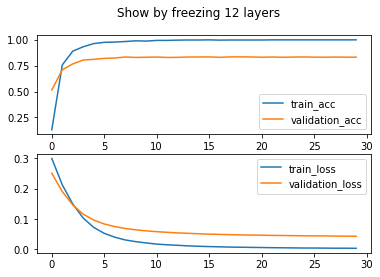

In [11]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Show by freezing 12 layers')
ax1.plot(torch.tensor(train_log[0] , device = 'cpu').tolist())
ax1.plot(torch.tensor(valid_log[0] , device = 'cpu').tolist())
ax1.legend(['train_acc','validation_acc'])
ax2.plot(torch.tensor(train_log[1] , device = 'cpu').tolist())
ax2.plot(torch.tensor(valid_log[1] , device = 'cpu').tolist())
ax2.legend(['train_loss','validation_loss'])

In [13]:
test_acc = test(model,device=device,label_maps=label_maps,test_loader=test_loader,data_size=len(test_data),tokenizer=tokenizer)

correct : 3719
total : 4500


In [14]:
print(f'Accuracy : {100 * test_acc} %') 

Accuracy : 82.64444444444445 %


In [26]:
PATH = f'../../../fewshot_models/saved_model.pth'
best_model = AutoModelForSequenceClassification.from_config(config)
# Model class must be defined somewhere
best_model.load_state_dict(torch.load(PATH))
best_model = best_model.to(device)

In [27]:
test_acc = test(best_model,device=device,label_maps=label_maps,test_loader=test_loader,data_size=len(test_data),tokenizer=tokenizer)

correct : 3634
total : 4500


In [28]:
print(f'Accuracy : {100 * test_acc} %') 

Accuracy : 80.75555555555556 %
